# Domain Relevance Evaluation

Comparing different methods to get domain relevant terms 

In [1]:
import pandas as pd
from tqdm import tqdm
from parts import collect, oie, domain_relevance, cleaning

## Initial Load of Background Domains

!!! only needed first time -> choose to export data to resource folder for faster performance in the future !!!

In [ ]:
adac_corpus = collect.get_corpus(0,"adac",0,0)

In [ ]:
chefkoch_corpus = collect.get_corpus("https://www.chefkoch.de/forum/1,27/Haus-Garten.html","chefkoch",5,0)

In [ ]:
car_corpus = collect.get_corpus("https://www.motor-talk.de/forum/audi-80-90-100-200-v8-b158.html","car",3,0)

## Load Background Domains and Extract Terms

In [38]:
adac_domain = collect.load_domain_terms("adac", 10000, 1)

100%|██████████| 2524/2524 [01:36<00:00, 26.11it/s]


deleted time references: 0
deleted date references: 287
deleted links: 77
deleted quotes: 63
deleted ireg expressions: 38
deleted abbreviations: 206


In [39]:
car_domain = collect.load_domain_terms("car", 10000, 1)

100%|██████████| 174/174 [00:18<00:00,  9.39it/s]


deleted time references: 19
deleted date references: 29
deleted links: 89
deleted quotes: 367
deleted ireg expressions: 122
deleted abbreviations: 241


In [40]:
chefkoch_domain = collect.load_domain_terms("chefkoch", 10000, 1)

100%|██████████| 279/279 [01:23<00:00,  3.35it/s]


deleted time references: 0
deleted date references: 692
deleted links: 156
deleted quotes: 419
deleted ireg expressions: 321
deleted abbreviations: 491


## Calculate Metrics 

In [ ]:
metric = "tf"

In [ ]:
adac_relevance = domain_relevance.get_relevancy(adac_domain, metric)

In [ ]:
car_relevance = domain_relevance.get_relevancy(car_domain, metric)

In [ ]:
chefkoch_relevance = domain_relevance.get_relevancy(chefkoch_domain, metric)

In [ ]:
alpha = 0.5
candidates = set([item for sublist in car_domain for item in sublist])
dw = domain_relevance.get_dw(car_domain, chefkoch_domain, candidates, alpha)

In [ ]:
llr = domain_relevance.get_llr(car_domain, chefkoch_domain, candidates)

In [ ]:
lor_bg = domain_relevance.get_lor_bg(car_domain, chefkoch_domain, candidates)

## Evaluation of Metrics and Domains

In [90]:
import matplotlib.pyplot as plt

### Distribution of metrics

In [ ]:
### Term frequency distribution in car_domain
from collections import Counter
flat_terms = [item for sublist in chefkoch_domain for item in sublist]
tf = Counter(flat_terms)
bins= range(0,15,1)
plt.hist(tf.values(), bins=bins, edgecolor="k")
plt.xticks(bins)
print(min(tf.values()),max(tf.values()))

In [ ]:
# distribution of llr, dw, lor, lor_bg values (just exchange for fitting metric)
bins= range(int(min(llr.values()))-1,int(min(llr.values()))+10,1)
plt.hist(llr.values(), bins=bins, edgecolor="k")
plt.xticks(bins)
print(min(llr.values()),max(llr.values()))

In [ ]:
# overview of highest and lowest performing terms in metric
pd.Series(tf).sort_values(ascending = False).head(15)

In [ ]:
len(candidates)
counter = 0
chefkoch_terms = set([item for sublist in chefkoch_domain for item in sublist])
for term in candidates:
    if term in chefkoch_terms and tf[term] > 1:
        counter += 1
        
counter

## Test Concept Export and Import

In [ ]:
#concepts = list(set([item for sublist in adac_domain for item in sublist]))
with open("concepts.txt", "w") as fp:
    fp.writelines('\n'.join(concepts))

In [ ]:
with open("concepts.txt", "r") as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

## Generate Random Testset and Test Concept generation

In [ ]:
#from random import sample
#
#testset = sample(candidates, 1000)

In [5]:
with open("testset.txt", "r") as f:
    testset = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
testset = [x.strip() for x in testset] 

In [6]:
import csv
reader = csv.reader(open('testset_labeled.csv', 'r'),delimiter=';')
labeled = {}
for row in reader:
    k,v = row
    labeled[k] = v

In [187]:
labels = domain_relevance.label_concepts(car_domain, adac_domain, chefkoch_domain, "dw")

100%|██████████| 279/279 [00:00<00:00, 17468.18it/s]

Chosen via background domain: 974
Chosen via metric: 1486
Chosen via tf > 1 limit: 1927


In [126]:
predicted = {}
for candidate in testset:
    predicted[candidate] = labels[candidate]

In [127]:
import pandas as pd

df = pd.DataFrame.from_dict(labeled,orient='index', columns = ["label"])
df["predicted"] = predicted.values()

In [128]:
from sklearn.metrics import confusion_matrix, classification_report

In [129]:
confusion_matrix(pd.to_numeric(df["label"]), pd.to_numeric(df["predicted"]))

array([[  0, 165],
       [  0, 335]])

In [119]:
print(classification_report(pd.to_numeric(df["label"]), pd.to_numeric(df["predicted"])))

              precision    recall  f1-score   support

           0       0.66      0.41      0.51       165
           1       0.76      0.90      0.82       335

    accuracy                           0.74       500
   macro avg       0.71      0.65      0.66       500
weighted avg       0.72      0.74      0.72       500



## Advanced Domain Selection 
First choose ADAC terms based on frequency -> choose Autoforum/Chefkoch terms based on newly defined shared domain -> sort remaining Autoforum terms by frequency or other metric 

In [84]:
tf_target, tf_contrast, dw, llr, lor_bg = domain_relevance.get_metrics(shared_target_domain, shared_contrastive_domain, "tf")

-3.828641396489095 1.6094379124341005


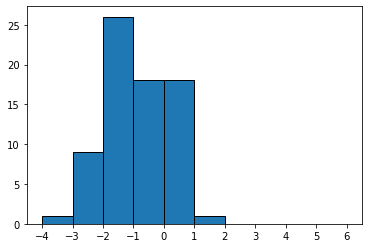

In [134]:
# distribution of llr, dw, lor, lor_bg values (just exchange for fitting metric)
bins= range(int(min(llr.values()))-1,int(min(llr.values()))+10,1)
plt.hist(llr.values(), bins=bins, edgecolor="k")
plt.xticks(bins)
print(min(llr.values()),max(llr.values()))

In [188]:
# overview of highest and lowest performing terms in metric
pd.Series(llr).sort_values(ascending = False).tail(5)

geld       -2.302585
tipp       -2.351375
hallo      -2.458238
zitat      -2.730029
maschine   -3.828641
dtype: float64

In [195]:

def label_shared_concepts(target_domain, contrastive_domain, method, metric):
    label = {}
    shared_target_domain, shared_contrastive_domain = domain_relevance.get_shared_domain(target_domain, contrastive_domain)
    tf_target, tf_contrast, dw, llr, lor_bg = domain_relevance.get_metrics(shared_target_domain, shared_contrastive_domain, metric)

    candidates = set([item for sublist in shared_target_domain for item in sublist])

    for candidate in candidates:
        label[candidate] = 0
        if tf_target[candidate] > tf_contrast[candidate] and not method:
            label[candidate] = 1
        elif llr[candidate] > 0 and method == "llr":
            label[candidate] = 1
        elif lor_bg[candidate] > 0 and method == "lor_bg":
            label[candidate] = 1
        elif dw[candidate] > 200 and method == "dw":
            label[candidate] = 0
        elif method == "del":
            pass

    return label

In [197]:
test_dudu = domain_relevance.label_shared_concepts(car_domain, chefkoch_domain, "dw", "tf")
counter = 0
for bla in test_dudu:
    if test_dudu[bla]:
        counter += 1
counter

100%|██████████| 279/279 [00:00<00:00, 23203.28it/s]


1771